#

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scripts.db_connector import get_connection


In [42]:
data = pd.read_excel('data/Online Retail.xlsx')


## Data Cleaning

In [64]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  Int64         
 7   Country      401604 non-null  object        
 8   TotalAmount  401604 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 31.0+ MB


In [47]:
data['CustomerID'].isna()

np.int64(135080)

In [48]:
# Drop rows with missing values
data = data.dropna()

# Drop duplicates
data = data.drop_duplicates()


In [49]:
# Add TotalAmount column
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']


In [63]:
data['InvoiceNo'] = data['InvoiceNo'].astype(str)
data['StockCode'] = data['StockCode'].astype(str)
data['Description'] = data['Description'].str.strip()
data['Quantity'] = data['Quantity'].astype(int)
data['UnitPrice'] = data['UnitPrice'].round(2)
data['CustomerID'] = data['CustomerID'].astype('Int64') 
data['Country'] = data['Country'].str.strip()
data['TotalAmount'] = (data['Quantity'] * data['UnitPrice']).round(2)

In [53]:
revenue_by_date = data.groupby('InvoiceDate')['TotalAmount'].sum().reset_index()


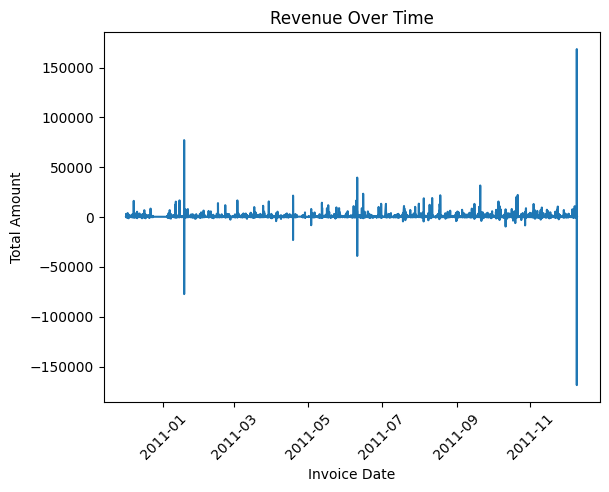

In [56]:
# Create a line plot
plt.plot(revenue_by_date['InvoiceDate'], revenue_by_date['TotalAmount'])

# Add labels and title
plt.xlabel('Invoice Date')
plt.ylabel('Total Amount')
plt.title('Revenue Over Time')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()

## 4. Transform Data for Database

In [57]:
# Products table
products = data[['StockCode', 'Description', 'UnitPrice']].drop_duplicates()
products.rename(columns={'StockCode': 'product_id'}, inplace=True)


In [58]:
# Customer table
customers = data[['CustomerID', 'Country']].drop_duplicates()
customers.rename(columns={'CustomerID': 'customer_id'}, inplace=True)


In [59]:
# Orders Table
orders = data[['InvoiceNo', 'InvoiceDate', 'CustomerID']].drop_duplicates()
orders.rename(columns={'InvoiceNo': 'order_id', 'CustomerID': 'customer_id'}, inplace=True)


In [60]:
# Orders Details
order_details = data[['InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice', 'TotalAmount']]
order_details.rename(columns={
    'InvoiceNo': 'order_id',
    'StockCode': 'product_id'
}, inplace=True)

/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_67912/1151544223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_details.rename(columns={


/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_67912/1874433104.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, conn)


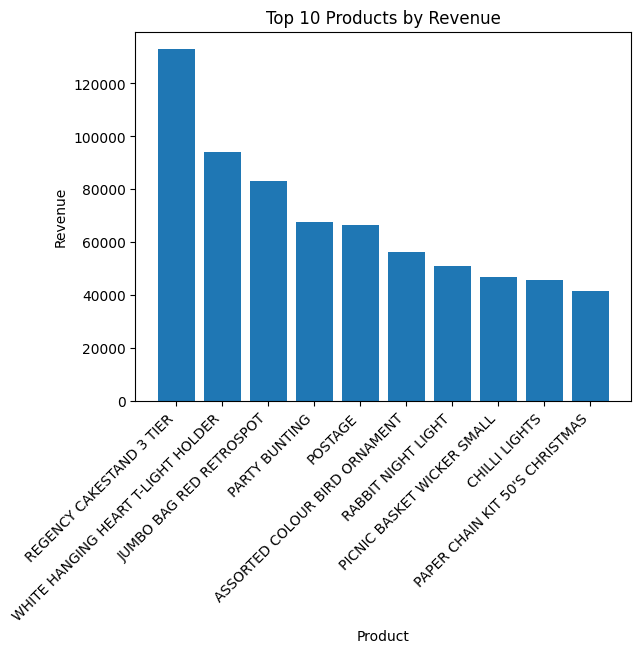

In [67]:

conn = get_connection()
query = """
    SELECT P.product_name, SUM(OD.total_amount) AS total_revenue
    FROM OrderDetails OD
    JOIN Products P ON OD.product_id = P.product_id
    GROUP BY P.product_name
    ORDER BY total_revenue DESC
    LIMIT 10;
"""
data = pd.read_sql(query, conn)
conn.close()

# Plot the data
plt.bar(data['product_name'], data['total_revenue'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Product')
plt.ylabel('Revenue')
plt.show()
